# Probabilistic Expected Utility

Note: Part of this is an adaption of https://towardsdatascience.com/an-introduction-to-bayesian-inference-in-pystan-c27078e58d53

Related documentation:
* https://mc-stan.org/docs/2_23/stan-users-guide/example-decision-analysis.html
* https://mc-stan.org/docs/2_25/stan-users-guide/examples.html

In [1]:
import os
import pickle
import pystan
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import multiprocessing
from scipy.special import expit
multiprocessing.set_start_method("fork")
sns.set()  # Nice plot aesthetic

In [2]:
# Set seed
np.random.seed(123)

The utility of a normalized outcome $x \in [0, 1]$ is defined as:
\begin{equation}
u(x) = x^{1 - \alpha}
\end{equation}

The expected utility of a lottery $L = \{(p_1, x_1), \dots, (p_n, x_n)\}$ is defined as:
\begin{equation}
EU(L) = \sum_{i=1}^{n} p_i u(x_i)
\end{equation}

The probability to choose the lottery $L_k \in \mathcal{L} = \{L_1, \dots, L_{N}\}$ is defined as: 
\begin{equation}
P(L_k) = \frac {e^{EU(L_k) / \tau}}{\sum _{i=1}^{N} e^{EU(L_i) / \tau } }
\end{equation}

### Generate data

Note: We consider here a special case where $L = \{(p, x)\}$ (one lottery has one possible positive output).

In [3]:
# True parameters
alpha_true = 0.3
tau_true = 0.1

# Number of trials
n_trial = 1000

# Number of lottery per trial
n_lot = 2

p = np.random.random(size=(n_lot, n_trial))
x = np.random.random(size=(n_lot, n_trial))

u = x**(1-alpha_true)
eu = p * u

p_choice = np.exp(eu/tau_true)
p_choice /= p_choice.sum(axis=0)

y = np.zeros(n_trial, dtype=int)
for i in range(n_trial):
    y[i] = np.random.choice(np.arange(n_lot), p=p_choice[:, i])

In [4]:
df_data = pd.merge(
    pd.DataFrame(x.T, columns=[f"x{i}" for i in range(n_lot)]), 
    pd.DataFrame(p.T, columns=[f"p{i}" for i in range(n_lot)]), left_index=True, right_index=True)
df_data['y'] = y
df_data

,x0,x1,p0,p1,y
0,0.423016,0.969426,0.696469,0.081894,0
1,0.393018,0.721784,0.286139,0.495040,1
2,0.036701,0.181892,0.226851,0.288890,1
3,0.884020,0.882028,0.551315,0.639992,0
4,0.676480,0.477022,0.719469,0.499936,0
...,...,...,...,...,...
995,0.610117,0.551774,0.264397,0.193012,0
996,0.621986,0.544699,0.690915,0.731650,0
997,0.208917,0.737517,0.347146,0.274711,1
998,0.567472,0.703100,0.004168,0.721818,1


## Inference using Stan

### Define the model

Note: in Stan language, vector indexes start from 1 (unlike Python thats starts from 0) 

In [5]:
model = """
data {
    int<lower=0> n_trial;
    int<lower=0> n_lot;
    matrix[n_lot, n_trial] x;
    matrix[n_lot, n_trial] p;
    int<lower=0,upper=1> y[n_trial];
}
parameters {
    real<lower=-1, upper=0.5> alpha;
    real<lower=0.01> tau;
}
model {
    for (i in 1: n_trial) {
        vector[n_lot] v;
        vector[n_lot] p_choice;
        int c;
        real p_c;
        for (j in 1: n_lot) {
            v[j] = (p[j, i] * pow(x[j, i], 1-alpha)) / tau;
        }
        p_choice = softmax(v);
        c = y[i]+1;
        p_c = p_choice[c];
        target += log(p_c);
    }
}
"""

### Format the data

In [6]:
data = {'n_trial': n_trial, 'n_lot': n_lot, 'x': x, 'p': p, 'y': y}

### Compile the model

*Note: Set `force_compilation = False` to avoid the (quite long) compilation of the model if you didn't make any change since the last compilation*

In [7]:
# Put it to true if you edit the model
force_compilation = True

# Where to save backup
bkp_folder = 'bkp'
os.makedirs(bkp_folder, exist_ok=True)
bkp_file = os.path.join(bkp_folder, 'peu_model.pkl')

if not os.path.exists(bkp_file) or force_compilation is True:
    
    # Compile the model
    sm = pystan.StanModel(model_code=model)
    
    # Save the model
    with open(bkp_file, 'wb') as f:
        pickle.dump(sm, f)
else:
    # Load the model
    sm = pickle.load(open(bkp_file, 'rb'))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_74808d0220f7070729180ce7a4b92cb1 NOW.


### Sampling

* `iter`: number of samples that will be generated from each Markov chain.
* `chains`: number of chains from which samples will be combined to form the posterior distribution. Because the underlying Markov process is stochastic, it's advantageous to have more chains that will initialise at different locations in parameter space, though adding more chains will increase the amount of time it takes to sample. 
* `warmup` (also known as 'burn-in'): number of samples that will be discarded from the beginning of each chain. As the early samples will be drawn when the Markov chain hasn't had a chance to reach equilibrium. By default this is half of iter, so for each chain we'll get 1000 samples, and chuck away the first 500. With 4 chains, we'll have 2000 samples in total.
* `thin`: interval in sampling at which samples are retained. E.g.: if thin is set to 3, every third sample is retained and the rest are discarded. This can be necessary to mitigate the effect of correlation between successive samples. If thin is set to 1 (like here), every sample is retained. 
* `seed`: Seed for the random generator. It allows for reproducibility.

In [8]:
# Train the model and generate samples
fit = sm.sampling(data=data, iter=1000, chains=4, warmup=500, thin=1, seed=101)
fit

Inference for Stan model: anon_model_74808d0220f7070729180ce7a4b92cb1.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   0.26  1.9e-3   0.06   0.14   0.23   0.27    0.3   0.38    958    1.0
tau      0.1  1.7e-4 6.7e-3   0.08   0.09    0.1    0.1   0.11   1458    1.0
lp__  -315.2    0.04   1.04 -317.9 -315.6 -314.9 -314.4 -314.1    871    1.0

Samples were drawn using NUTS at Mon Jan 11 12:49:23 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [9]:
# Cast the fit output to a pandas DataFrame
summary_dict = fit.summary()
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])
df

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
alpha,0.263745,0.001948,0.060288,0.143416,0.226083,0.266795,0.304427,0.376711,957.862831,1.002589
tau,0.095428,0.000174,0.006655,0.083594,0.090836,0.095032,0.099933,0.109440,1458.367656,1.000732
lp__,-315.210387,0.035159,1.037558,-317.922763,-315.604510,-314.902646,-314.486876,-314.190937,870.844729,1.000421


### Plot the results

In [10]:
# Select a subset of samples to plot
n = 1000
idx = np.random.choice(range(len(fit['alpha'])), size=n, replace=False)

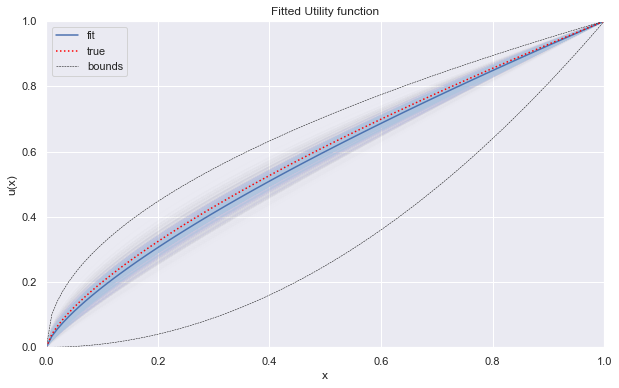

In [11]:
# Utility function
def f(x, alpha):
    return x**(1-alpha)

# Extract mean
alpha_mean = df['mean']['alpha']

# Extrac trace
alpha = fit['alpha']

# Create fig
fig, ax = plt.subplots(figsize=(10, 6))

# Set limits
x_min, x_max = 0, 1
y_min, y_max = 0, 1

# Generate x-values
x = np.linspace(x_min, x_max, 100)

# Plot a subset
for i in idx:
    ax.plot(x, f(x, alpha[i]), color='lightsteelblue', alpha=0.005 )

# Plot mean
ax.plot(x, f(x, alpha_mean), label="fit")

# Plot truth
ax.plot(x, f(x, alpha_true), ls=':', label='true', color="red")

# Plot bounds
ax.plot(x, f(x, -1), color='0.01', ls='--', lw=0.5, label="bounds")
ax.plot(x, f(x, 0.5), color='0.01', ls='--', lw=0.5)

# Pimp your plot
ax.set_xlabel('x')
ax.set_ylabel('u(x)')
ax.set_title('Fitted Utility function')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.legend()

plt.show()

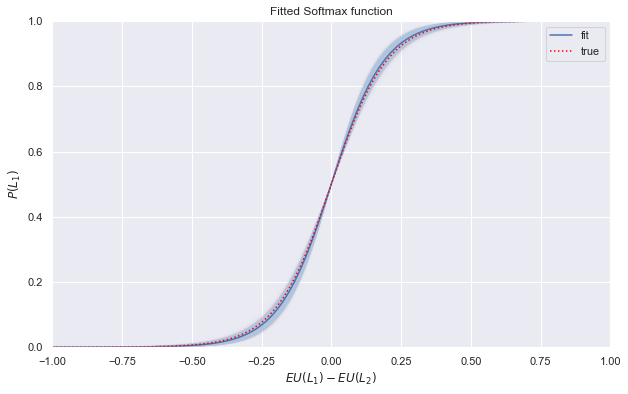

In [21]:
# Softmax function given the difference of value between 2 options
def f(x, tau):
    return expit(x/tau)

# Extract mean
tau_mean = df['mean']['tau']

# Extrac trace
tau = fit['tau']

# Create fig
fig, ax = plt.subplots(figsize=(10, 6))

# Set limits
x_min, x_max = -1, 1
y_min, y_max = 0, 1

# Generate x-values
x = np.linspace(x_min, x_max, 100)

# Plot a subset
for i in idx:
    ax.plot(x, f(x, tau[i]), color='lightsteelblue', alpha=0.005)

# Plot mean
ax.plot(x, f(x, tau_mean), label="fit")

# Plot truth
ax.plot(x, f(x, tau_true), ls=':', label='true', color="red")

# Pimp your plot
ax.set_xlabel('$EU(L_1) - EU(L_2)$')
ax.set_ylabel('$P(L_1)$')
ax.set_title('Fitted Softmax function')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

ax.legend()
plt.show()

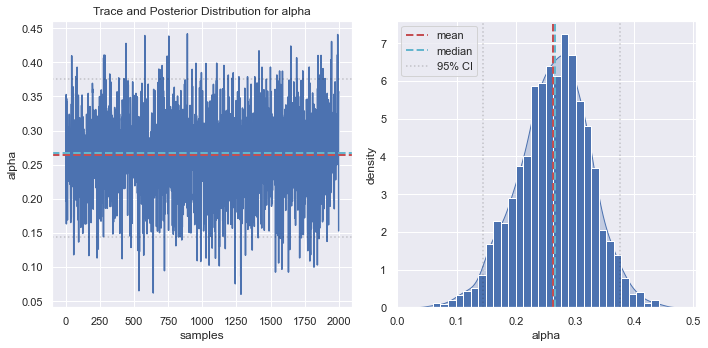

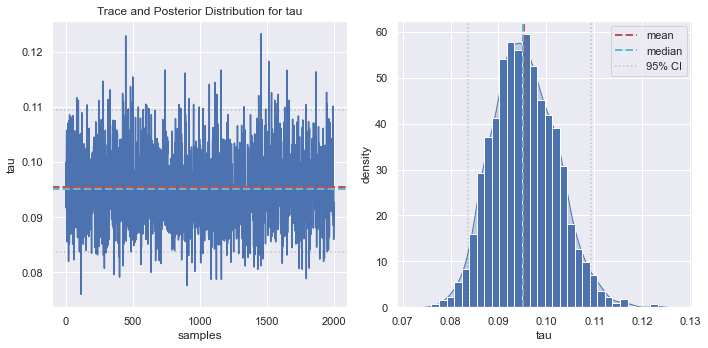

In [22]:
for param_name in ("alpha", "tau"):

    # Extract trace
    param = fit[param_name]
    
    # Summary statistics
    mean = np.mean(param)
    median = np.median(param)
    cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)

    # Plotting
    fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
    
    ax = axes[0] 
    ax.plot(param)
    ax.set_xlabel('samples')
    ax.set_ylabel(param_name)
    ax.axhline(mean, color='r', lw=2, linestyle='--')
    ax.axhline(median, color='c', lw=2, linestyle='--')
    ax.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
    ax.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
    ax.set_title('Trace and Posterior Distribution for {}'.format(param_name))

    ax = axes[1]
    ax.hist(param, 30, density=True); sns.kdeplot(param, shade=True)
    ax.set_xlabel(param_name)
    ax.set_ylabel('density')
    ax.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
    ax.axvline(median, color='c', lw=2, linestyle='--',label='median')
    ax.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
    ax.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
    ax.legend()
    
    plt.tight_layout()

## Using stochastic gradient descent

In [23]:
# Float precision
EPS = np.finfo(float).eps

In [24]:
# Discrepancy function (-likelihood sum)
def objective(param, data):
    
    alpha, tau = param

    n_lot = data['n_lot']
    p = data['p']
    x = data['x']
    y = data['y']
    
    u = x**(1-alpha)
    eu = p * u

    p_choice = np.exp(eu/tau)
    p_choice /= p_choice.sum(axis=0)
    
    lls = 0
    for i in range(n_lot):
        lls += np.log(p_choice[i, y==i] + EPS).sum()
    
    # Since we will look for the minimum, 
    # let's return -LLS instead of LLS
    return -lls

In [25]:
# Define bounds and an initial guess
bounds = (-1, 0.5), (0.01, None) 
init_guess = (0, 1)

# Run the optimizer
res = scipy.optimize.minimize(
    fun=objective,
    x0=init_guess,
    bounds=bounds,
    args=(data, ))
res

      fun: 310.0926631505294
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.68434189e-06, -1.42108547e-04])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 42
      nit: 8
     njev: 14
   status: 0
  success: True
        x: array([0.26694072, 0.09460986])

A '[OptimizeResult](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.OptimizeResult.html#scipy.optimize.OptimizeResult)' is returned. It contains:
* `fun` (NumPy array): Value of objective function.
* `hess_inv` (object): Inverse of the objective function’s Hessian; may be an approximation. Not available for all solvers. The type of this attribute may be either np.ndarray or scipy.sparse.linalg.LinearOperator. Here, it is a scipy.sparse.linalg.LinearOperator.
* `jac` (NumPy array): Value of the Jacobian.
* `nfev` (int): Number of evaluations of the objective functions.
* `message` (str): Description of the cause of the termination.
* `nit` (int): Number of iterations performed by the optimizer.
* `njev` (int): Number of evaluations of the objective functions and of its Jacobian.
* `status` (int): Termination status of the optimizer. Its value depends on the underlying solver. Refer to message for details.
* `success` (bool): Whether or not the optimizer exited successfully.
* `x` (NumPy array): the solution of the optimization.

In [26]:
# Extract the best param and best value 
best_param = res.x
best_value = res.fun

print("Estimation parameters: ", best_param)
print("LLS: ", - best_value)

Estimation parameters:  [0.26694072 0.09460986]
LLS:  -310.0926631505294


In [27]:
alpha_est, tau_est = res.x
print("est. alpha:", alpha_est)
print("est. tau:", tau_est)

est. alpha: 0.2669407216726797
est. tau: 0.09460986454774618


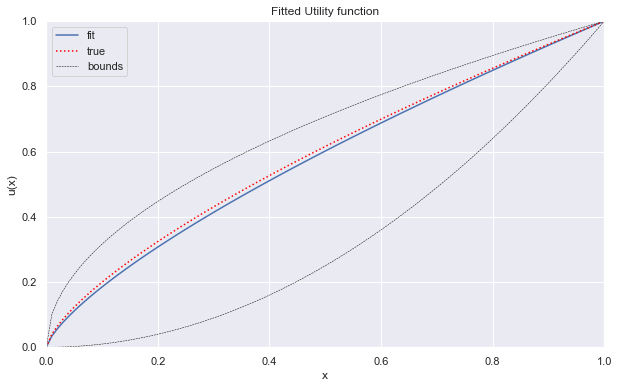

In [28]:
# Utility function
def f(x, alpha):
    return x**(1-alpha)

# Create fig
fig, ax = plt.subplots(figsize=(10, 6))

# Set limits
x_min, x_max = 0, 1
y_min, y_max = 0, 1

# Generate x-values
x = np.linspace(x_min, x_max, 100)

# Plot estimate
ax.plot(x, f(x, alpha_est), label="fit")

# Plot truth
ax.plot(x, f(x, alpha_true), ls=':', label='true', color="red")

# Plot bounds
ax.plot(x, f(x, -1), color='0.01', ls='--', lw=0.5, label="bounds")
ax.plot(x, f(x, 0.5), color='0.01', ls='--', lw=0.5)

# Pimp your plot
ax.set_xlabel('x')
ax.set_ylabel('u(x)')
ax.set_title('Fitted Utility function')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.legend()

plt.show()

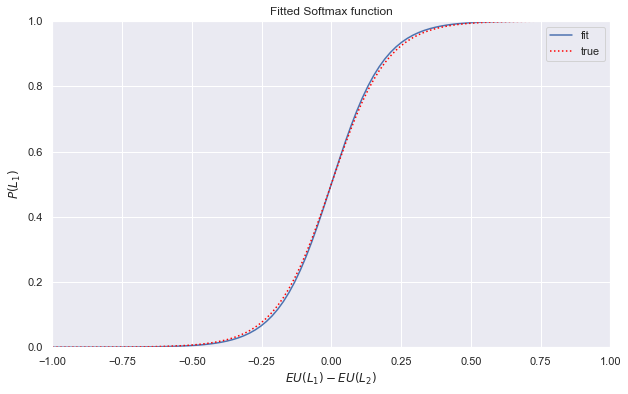

In [29]:
# Softmax function given the difference of value between 2 options
def f(x, tau):
    return expit(x/tau)

# Create fig
fig, ax = plt.subplots(figsize=(10, 6))

# Set limits
x_min, x_max = -1, 1
y_min, y_max = 0, 1

# Generate x-values
x = np.linspace(x_min, x_max, 100)

# Plot estimate
ax.plot(x, f(x, tau_est), label="fit")

# Plot truth
ax.plot(x, f(x, tau_true), ls=':', label='true', color="red")

# Pimp your plot
ax.set_xlabel('$EU(L_1) - EU(L_2)$')
ax.set_ylabel('$P(L_1)$')
ax.set_title('Fitted Softmax function')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.legend()

plt.show()